In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [14]:
def y2indicator(Y, K=10):
    # K=10 for MNIST
    # Python
    N = len(Y)
    Y = Y.astype(np.int32)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, Y[i]] = 1
    return ind
    
def get_normalized_data():
    df = pd.read_csv('../datasets/mnist/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    Y = data[:,0]
    X = data[:,1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std==0, 1)
    X = (X-mu)/std
    return X, Y

def error(p, t):
    return np.mean(p != t)

In [15]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1.0 / tf.sqrt(in_dim/2.0)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

def NN(X, W1, b1, W2, b2, W3, b3):
    Z1 = tf.nn.relu( tf.matmul(X,W1)+b1 )
    Z2 = tf.nn.relu( tf.matmul(Z1,W2)+b2 )
    return tf.matmul(Z2,W3)+b3

In [16]:
# Input
X, Y = get_normalized_data()
Xtrain = X[:-1000,]                                                         
Ytrain = Y[:-1000]                                                          
Xtest  = X[-1000:,]                                                         
Ytest  = Y[-1000:]                                                          
Ytrain_ind = y2indicator(Ytrain)                                            
Ytest_ind = y2indicator(Ytest)

# Parameters
lr = 1.0e-5
reg = 1.0e-2
N, D = Xtrain.shape
M1 = 300
M2 = 100
K=10

max_iter = 100
print_period = 10
batch_size = 500
n_batches = N//batch_size

In [17]:
X = tf.placeholder(tf.float32, shape=[None, D], name='X')
T = tf.placeholder(tf.float32, shape=[None, K], name='T')

W1 = tf.Variable(xavier_init([D, M1]), name='W1')
b1 = tf.Variable(tf.zeros(shape=[M1]), name='b1')
W2 = tf.Variable(xavier_init([M1, M2]), name='W2')
b2 = tf.Variable(tf.zeros(shape=[M2]), name='b2')
W3 = tf.Variable(xavier_init([M2, K]), name='W3')
b3 = tf.Variable(tf.zeros(shape=[K]), name='b3')

logits = NN(X, W1, b1, W2, b2, W3, b3)

cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=T, logits=logits))

#train_op = tf.train.GradientDescentOptimizer(0.001).minimize(cost)
train_op = tf.train.RMSPropOptimizer(lr, decay=0.99, momentum=0.9).minimize(cost)
predict_op = tf.argmax(logits, 1)

In [18]:
costs = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    for i in range(max_iter):
        for j in range(n_batches):
            batch_range = (j*batch_size, j*batch_size + batch_size)
        
            Xbatch = Xtrain[batch_range[0]:batch_range[1], ]                
            Ybatch = Ytrain_ind[batch_range[0]:batch_range[1], ]

            session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
        if i % print_period == 0:
            test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
            prediction = session.run(predict_op, feed_dict={X: Xtest})
            err = error(prediction, Ytest)
            print("Cost / err at iteration: {} / {}".format(test_cost, err))
            costs.append(test_cost)

Cost / err at iteration: 2.8718574047088623 / 0.935
Cost / err at iteration: 0.6607075333595276 / 0.177
Cost / err at iteration: 0.23873122036457062 / 0.054
Cost / err at iteration: 0.20023183524608612 / 0.039
Cost / err at iteration: 0.19418542087078094 / 0.033
Cost / err at iteration: 0.20481577515602112 / 0.028
Cost / err at iteration: 0.22485245764255524 / 0.028
Cost / err at iteration: 0.25088614225387573 / 0.029
Cost / err at iteration: 0.2757429778575897 / 0.026
Cost / err at iteration: 0.2947321832180023 / 0.026


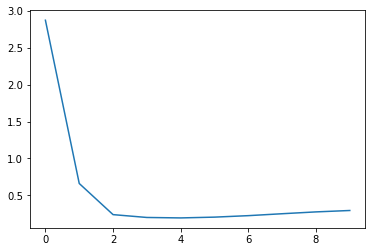

In [19]:
plt.plot(costs)
plt.show()